# Personality Extraction Based on User's Genre Preferences

In this Jupyter Notebook, the user's personality will be extracted based on their preferences for movie genres. The model we are using for measuring personality is Big Five. We will use this 5 features to improve the recommendations in a movie recommender system.

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import ast

import warnings
warnings.filterwarnings('ignore')

## Read the ratings datasets

First, load the original ratings and final ratings datasets. Then, select the previously filtered users along with their ratings for all movies. It's important not to use the filtered ratings dataset directly, as it doesn't include all movies—this could lead to inaccurate personality extraction.

In [114]:
# Original Dataset
odf = pd.read_parquet('../Data/Raw/ratings.parquet')
# Filtered users
fdf = pd.read_parquet('../Data/Processed/ratings_final.parquet')
# Select the ratings with all the movies with the filtered users
rdf = odf[odf['userId'].isin(fdf['userId'])]
rdf.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [115]:
print(f'We have {rdf.shape[0]:,} ratings from {len(rdf['userId'].unique()):,} users')

We have 12,602,925 ratings from 85,100 users


## Read the Movies Dataset

Now, we will read the movies dataset, extract the genres of each movie, remove those without a genre, and concatenate it with the ratings dataset to identify which movies the user has rated, enabling us to determine their preferences for movie genres.

In [116]:
mdf = pd.read_parquet('../Data/Raw/movies_metadata.parquet')
mdf = mdf[['movieId', 'title', 'genres']]
mdf.head()

,movieId,title,genres
0,16,Casino,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name..."
1,11,The American President,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
2,7,Sabrina,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ..."
3,8,Tom and Huck,"[{'id': 10751, 'name': 'Family'}, {'id': 28, '..."
4,1,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '..."


Extract the genres and delete those films without genre

In [117]:
mdf['genres'] =  mdf['genres'].apply(lambda x: ast.literal_eval(x)).apply(lambda x: [item['name'] for item in x])
mdf['genres'] = mdf['genres'].apply(lambda x: np.nan if not x else x)
mdf.dropna(subset='genres', inplace=True)

In [118]:
print(f'We end up with {mdf.shape[0]:,} movies')

We end up with 85,335 movies


Then we need to extract the personality of the users according to its preferences to the following genres:

- Action
- Adventure
- Animation 
- Comedy
- Drama
- Horror
- Romance
- Sci-fi
- War

So we are going to select only the films that have at least one of the previous genres

In [119]:
genres = {'Action', 'Adventure', 'Animation', 'Comedy', 'Drama', 'Horror', 'Romance', 'Science Fiction', 'War'}
def select_genres(x):
    new = [genre for genre in x if genre in genres]
    return new if new else np.nan

In [120]:
# Select only the genres we want. If a film does not have a genre, we set it null
mdf['genres'] = mdf['genres'].apply(lambda x: select_genres(x))
# Delete the movies that does not have the desires genres
mdf = mdf.dropna(subset='genres')
print(f'We have {mdf.shape[0]:,} movies that have at least one of the desired genres')

We have 72,381 movies that have at least one of the desired genres


### Join the ratings and movies dataframes

Join both dataframes to know the average rating each user give to each genres, and see their preferences

In [121]:
# Merge the dataframes
df = mdf.merge(rdf, on='movieId')
# select only the users who have rated more than 100 films
df = df.groupby('userId').filter(lambda x: len(x) > 100)
# Select the relevant features
df = df[['userId', 'genres', 'rating']]
df.head()

,userId,genres,rating
0,33,[Drama],4.5
2,48,[Drama],5.0
5,86,[Drama],5.0
6,96,[Drama],4.0
7,103,[Drama],4.5


In [122]:
print(f'We have {df.shape[0]:,} ratings of {len(df["userId"].unique()):,} users that had voted at least 100 movies')

We have 9,761,982 ratings of 53,321 users that had voted at least 100 movies


### Get the mean rating per genre for each user

In [123]:
# Expand the genres (1 per row)
df = df.explode('genres')
df.head(10)

,userId,genres,rating
0,33,Drama,4.5
2,48,Drama,5.0
5,86,Drama,5.0
6,96,Drama,4.0
7,103,Drama,4.5
8,130,Drama,5.0
9,176,Drama,4.0
10,209,Drama,4.5
12,218,Drama,4.5
13,226,Drama,3.0


We will determine how many movies the user has watched and calculate the proportion of each genre. Then, we will use these proportions to weight the average rating for each genre.

In [124]:
genre_counts = df.groupby(['userId', 'genres']).size().unstack(fill_value=0)
genre_counts.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,16,14,0,52,103,0,42,18,19
3,60,57,13,51,58,1,28,35,10
18,19,24,16,62,74,3,32,18,3
20,43,44,17,42,58,2,12,24,6
29,37,18,6,45,95,2,46,13,6


In [125]:
# Get the proportion per genre
genre_proportions = genre_counts.div(genre_counts.sum(axis=1), axis=0)
genre_proportions.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,0.060606,0.053030,0.000000,0.196970,0.390152,0.000000,0.159091,0.068182,0.071970
3,0.191693,0.182109,0.041534,0.162939,0.185304,0.003195,0.089457,0.111821,0.031949
18,0.075697,0.095618,0.063745,0.247012,0.294821,0.011952,0.127490,0.071713,0.011952
20,0.173387,0.177419,0.068548,0.169355,0.233871,0.008065,0.048387,0.096774,0.024194
29,0.138060,0.067164,0.022388,0.167910,0.354478,0.007463,0.171642,0.048507,0.022388


Get the rating average per genre for each user

In [126]:
# Obtain the average
df = df.groupby(by=['userId', 'genres']).aggregate('mean').reset_index()
df = df.pivot(index="userId", columns="genres", values="rating").reset_index()
df.set_index("userId", inplace=True) 
df = df.fillna(0)
df.head(10)

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,4.062500,3.428571,0.000000,3.307692,3.631068,0.000000,3.523810,4.000000,3.421053
3,3.583333,3.614035,3.961538,3.186275,4.103448,1.500000,3.625000,3.428571,4.000000
18,2.947368,3.458333,4.187500,3.677419,3.972973,4.500000,3.578125,3.305556,3.500000
20,3.860465,3.920455,4.205882,3.857143,3.655172,4.000000,3.458333,3.666667,3.333333
29,2.783784,2.944444,4.000000,3.222222,3.421053,2.500000,3.413043,2.769231,3.500000
33,4.033333,3.910448,4.400000,4.214286,4.376984,4.266667,4.066667,4.105769,4.380000
34,3.780000,3.712500,3.750000,3.590909,3.557377,3.500000,3.691176,3.583333,2.666667
36,3.540541,3.454545,3.571429,3.480000,3.746377,3.875000,3.250000,3.452381,3.750000
37,3.048193,2.957143,1.833333,2.903226,3.157407,2.533333,3.325000,2.750000,3.000000


### Plot the ratings distribution for each genre

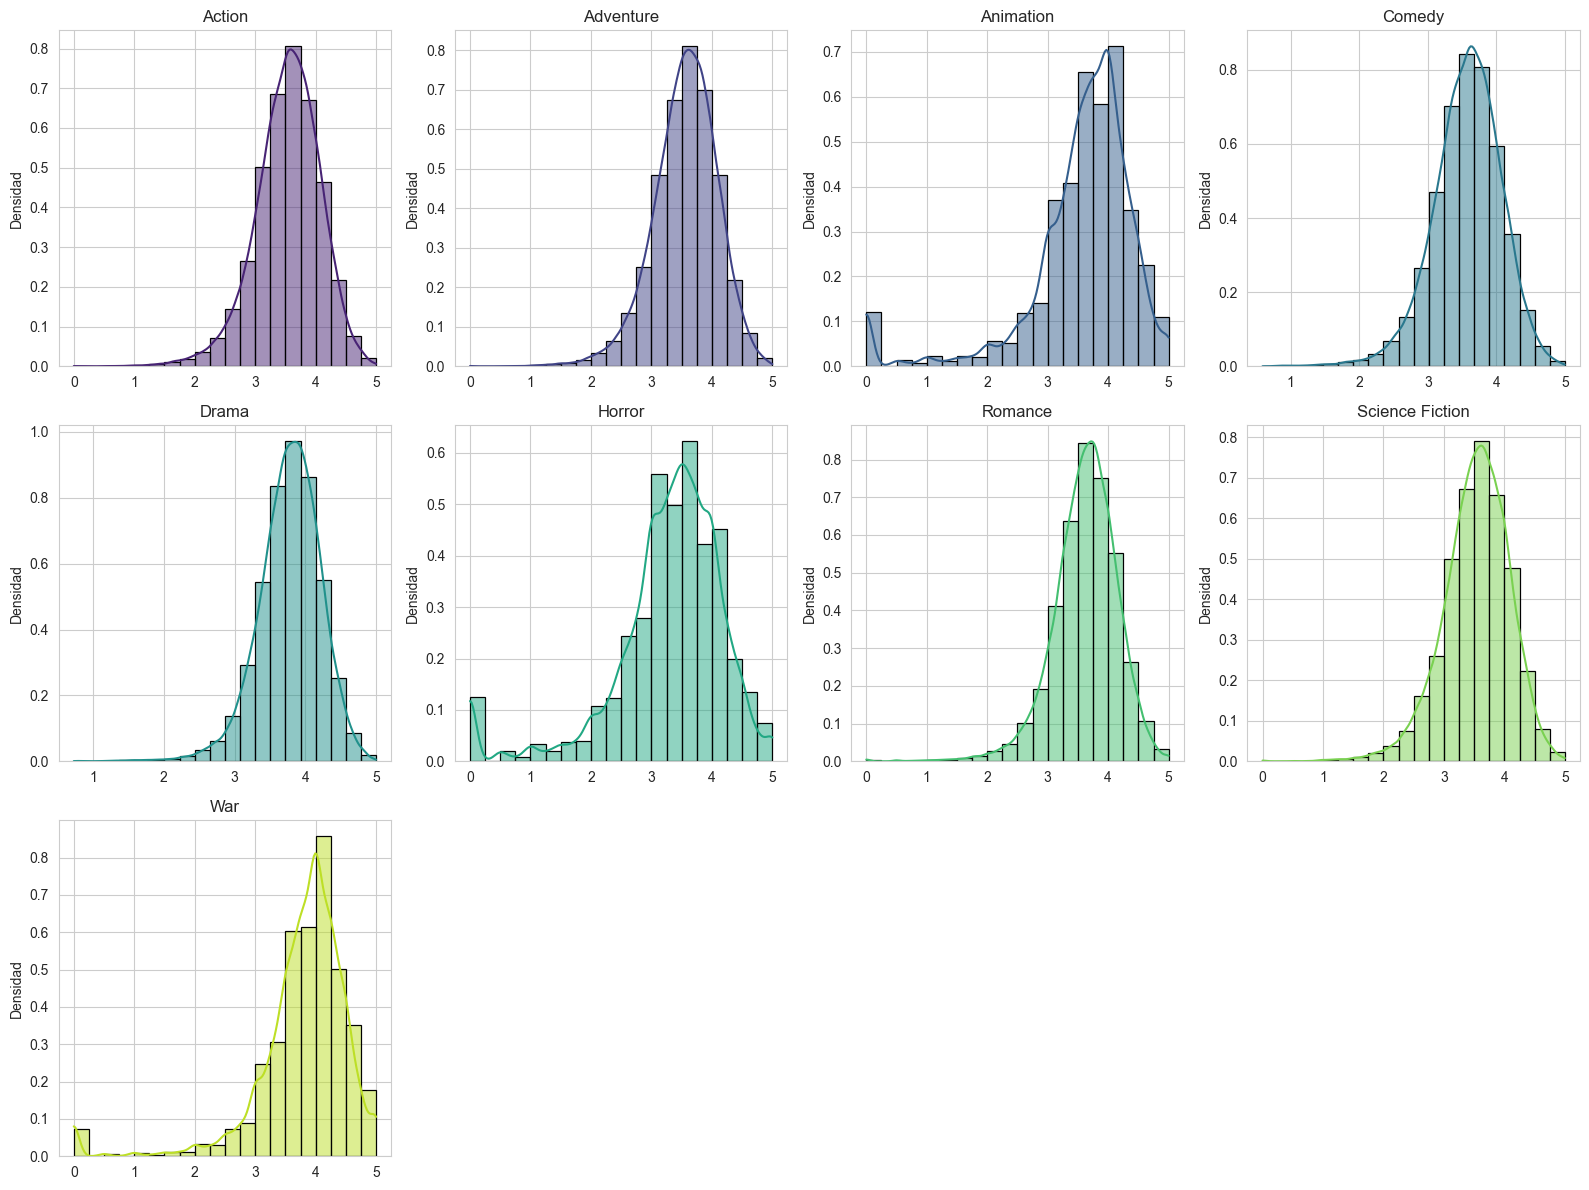

In [127]:
sns.set_style("whitegrid")
num_columns = len(df.columns)
rows = 3 
cols = 4 

# create the plot and the axis
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()
colors = sns.color_palette("viridis", num_columns)

# Plot each genre with its ratings distribution
for i, column in enumerate(df.columns):
    sns.histplot(df[column], bins=20, kde=True, ax=axes[i], color=colors[i], stat="density", edgecolor="black")
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Densidad")

# Hide void axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can observe that almost all genres, except for 'War', follow a normal distribution. This was expected, as most social events, such as weight, height, or people's ratings, tend to follow a normal distribution. In this case, the ratings for each genre follow this normal distribution, with a mean ranging from 3.2 to 3.8, depending on the genre.

### Traits scores per genre

In [128]:
personality = {
    "Action": [3.87, 3.45, 3.57, 3.58, 2.72],
    "Adventure": [3.91, 3.56, 3.54, 3.68, 2.61],
    "Animation": [4.04, 3.22, 3.26, 3.35, 3.02],
    "Comedy": [3.88, 3.44, 3.58, 3.60, 2.75],
    "Drama": [3.99, 3.43, 3.66, 3.60, 2.86],
    "Horror": [3.90, 3.38, 3.52, 3.47, 2.91],
    "Romance": [3.88, 3.44, 3.62, 3.62, 2.71],
    "Science Fiction": [3.99, 3.55, 3.53, 3.57, 2.73],
    "War": [3.82, 3.51, 3.49, 3.50, 2.71]
}

personality = pd.DataFrame.from_dict(personality, orient='index', columns=['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism'])
personality.head(10)

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
Action,3.87,3.45,3.57,3.58,2.72
Adventure,3.91,3.56,3.54,3.68,2.61
Animation,4.04,3.22,3.26,3.35,3.02
Comedy,3.88,3.44,3.58,3.60,2.75
Drama,3.99,3.43,3.66,3.60,2.86
Horror,3.90,3.38,3.52,3.47,2.91
Romance,3.88,3.44,3.62,3.62,2.71
Science Fiction,3.99,3.55,3.53,3.57,2.73
War,3.82,3.51,3.49,3.50,2.71


- OPE (Apertura): ~3.82-4.15
- CON (Responsabilidad): ~3.22-3.56
- EXT (Extraversión): ~3.26-3.66
- AGR (Amabilidad): ~3.35-3.68
- NEU (Neuroticismo): ~2.61-3.02

In [129]:
personality.mean()

Openness             3.920000
Conscientiousness    3.442222
Extraversion         3.530000
Agreeableness        3.552222
Neuroticism          2.780000
dtype: float64

In [130]:
personality.std()

Openness             0.071063
Conscientiousness    0.102198
Extraversion         0.113908
Agreeableness        0.098079
Neuroticism          0.125797
dtype: float64

## Obtaining Personality

Now, to obtain the personality, we will multiply the average ratings of the genres provided by each user by the personality matrix. We will do this using several methods until we achieve the best results. The steps are as follows:
1. Normalize the ratings
2. Multiply by the personality matrix
3. Re-scale the results to a 1-5 range

The following normalizations will be applied:
- The sum equals 1
- Min-Max Normalization
- Soft-Max Normalization
- Weighting by percentage of genres watched
- 50% Weighting of genres watched and 50% ratings

In [131]:
def plot(df):
    # Plot
    axes = df.hist(bins=20, figsize=(12, 6), edgecolor='black', grid=False)

    # Optional styling tweaks
    for ax in axes.flatten():
        ax.set_title(ax.get_title(), fontsize=12)
        ax.set_xlabel(ax.get_xlabel(), fontsize=10)
        ax.set_ylabel("Frequency", fontsize=10)
        ax.tick_params(axis='both', labelsize=9)

    plt.tight_layout()
    plt.show()

### Original Ratings, Without Normalization

As a first approximation, we will multiply the matrix of original ratings by the personality matrix. This will give us the users' personality on a different scale than the original one, so we will later return it to the original scale by dividing by the average ratings multiplied by 10 (number of genres) for each user.

In [132]:
# Multiply the users preference by the genre personality
df_personality = df @ personality
df_personality.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,99.150199,88.384163,90.587179,91.150305,69.220156
3,121.613496,106.771659,109.391640,110.209638,86.030011
18,129.958740,113.779930,116.798521,117.466429,92.465833
20,133.192261,116.757510,119.733782,120.537612,94.550969
29,112.010083,98.091570,100.603652,101.283662,79.551561


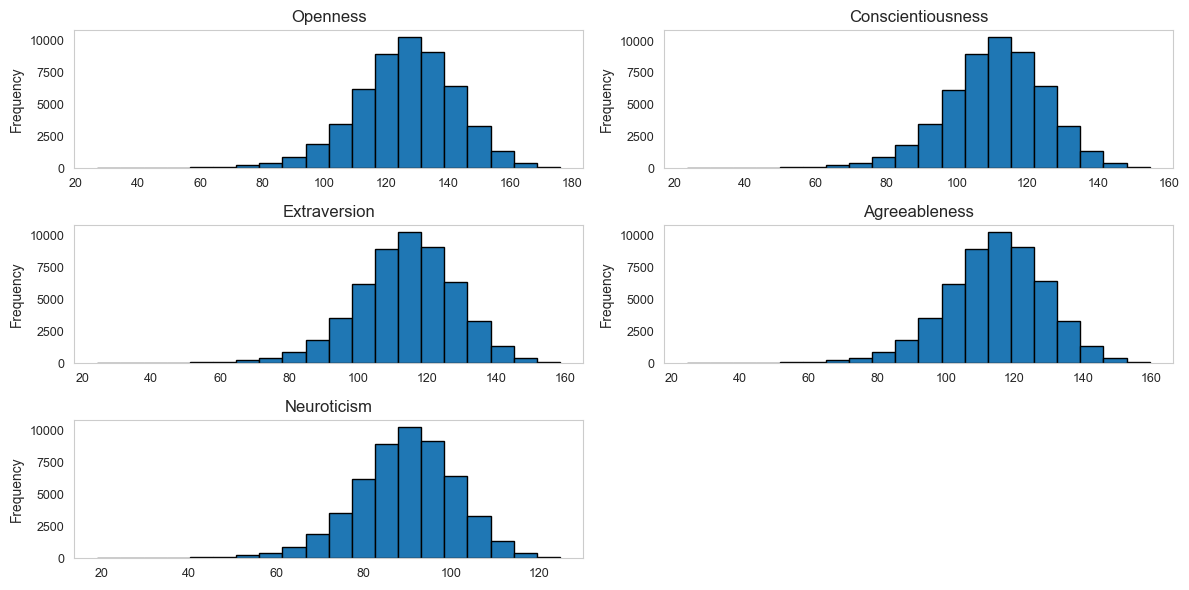

In [133]:
plot(df_personality)

We got a normal distribution, which is very good, the opness has the highest values, meanwhile neuroticism the lowest. Now we are going to return them to the original scale

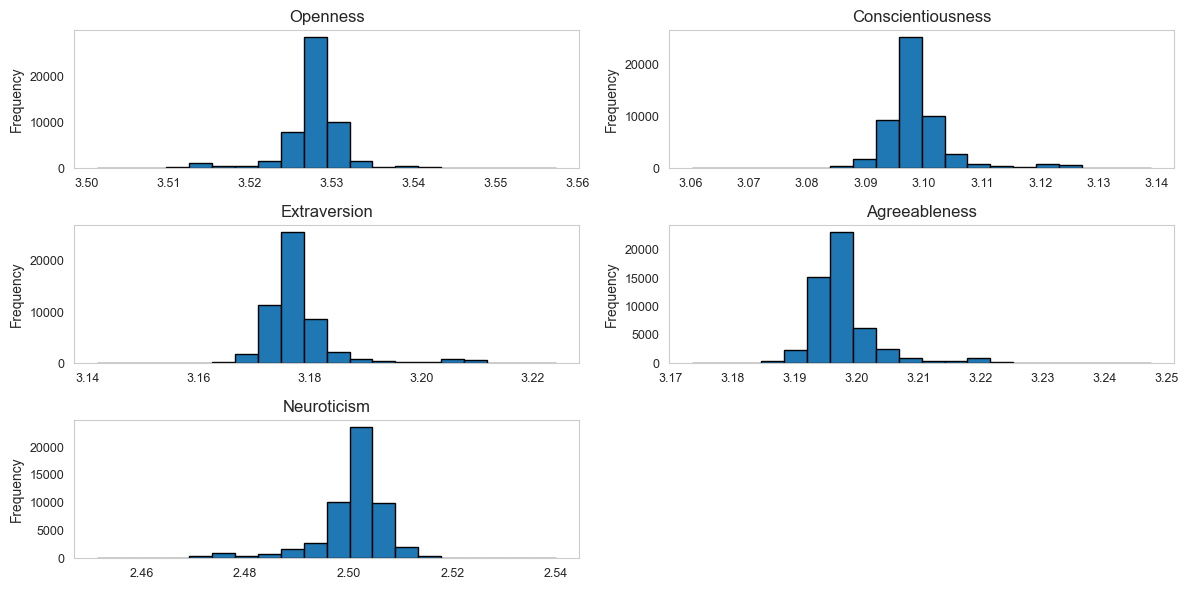

In [134]:
df_mean = df.mean(axis=1)
plot(df_personality.div(df_mean * 10, axis=0))

As we can see, we lost the normal distribution, since the scores collapsed when we try to get them back to the original scale.

### Divide by the Total Sum of Ratings

Since not all users utilize the full rating range, i.e., between 1 and 5, if we multiply the original ratings by the personality matrix, they will fall into a different range. Therefore, we will standardize the ratings by dividing them by the total sum of ratings per user, maintaining the same proportions for each user.

- Effect: The proportions will remain the same, but the scale will be consistent for all users.

In [135]:
# Normalize the ratings of each user
df_normalized = df.div(df.sum(axis=1), axis=0)
df_normalized.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,0.160100,0.135118,0.000000,0.130354,0.143098,0.000000,0.138871,0.157637,0.134821
3,0.115583,0.116573,0.127782,0.102776,0.132360,0.048384,0.116927,0.110591,0.129023
18,0.088971,0.104395,0.126406,0.111009,0.119931,0.135840,0.108011,0.099784,0.105653
20,0.113685,0.115452,0.123857,0.113588,0.107640,0.117794,0.101843,0.107978,0.098162
29,0.097493,0.103119,0.140087,0.112847,0.119811,0.087554,0.119530,0.096983,0.122576


In [136]:
# Personality per user
res_normalized = df_normalized @ personality
res_normalized.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,3.907444,3.483162,3.569981,3.592174,2.727921
3,3.922737,3.444003,3.528512,3.554897,2.774965
18,3.923013,3.434630,3.525751,3.545913,2.791230
20,3.922328,3.438347,3.525994,3.549666,2.784395
29,3.922776,3.435327,3.523304,3.547120,2.786026


The ratings are almost the same for each user, this is a wrong approach.

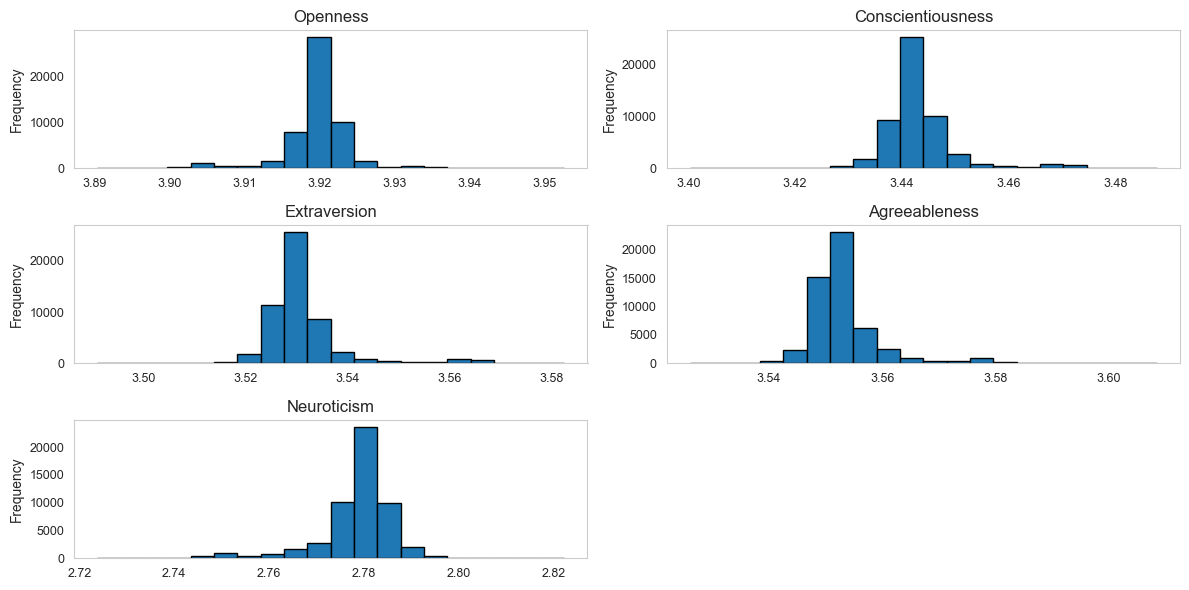

In [137]:
plot(res_normalized)

The personality of all users seems to be exactly the same, with only minor decimal differences. This is because the personality matrix has very similar values with low variability, and the same happens with the users' average ratings. Most users rate movies with an average between 3 and 4, so when multiplying the matrices, the resulting values become condensed, indicating a loss of variability. To introduce greater differences, we need to use a standardization method that gives more weight to higher ratings.

### Min-Max Normalization

We want to increase the diversity of genres a user watches, where higher ratings have more influence. In this case, the lowest rating is assigned a 0, and the highest rating is assigned a 1, differentiating the ratings more.

- Effect: Scales all ratings to the same range (0 to 1), maintaining the same relative distribution.
- Expected Distribution: With a higher bias towards genres with extreme ratings.

$$ X' = \frac{X - Xmin}{Xmax - Xmin}$$

In [138]:
# Normalización Min-Max por usuario
df_min_max = (df - df.min(axis=1).values.reshape(-1,1)) / (df.max(axis=1) - df.min(axis=1)).values.reshape(-1,1)
df_min_max.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,1.000000,0.843956,0.000000,0.814201,0.893801,0.000000,0.867399,0.984615,0.842105
3,0.800221,0.812013,0.945492,0.647708,1.000000,0.000000,0.816225,0.740776,0.960265
18,0.000000,0.329096,0.798729,0.470202,0.660559,1.000000,0.406250,0.230697,0.355932
20,0.604129,0.672880,1.000000,0.600321,0.368849,0.764045,0.143258,0.382022,0.000000
29,0.189189,0.296296,1.000000,0.481481,0.614035,0.000000,0.608696,0.179487,0.666667


In [139]:
res_min_max = df_min_max @ personality
res_min_max.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,24.406203,21.756102,22.298383,22.436998,17.038808
3,26.385581,23.162227,23.713411,23.912378,18.629143
18,16.730036,14.472497,14.917014,14.967530,12.058672
20,17.869782,15.461416,15.854447,16.011645,12.779762
29,15.873388,13.761047,14.119101,14.239108,11.334374


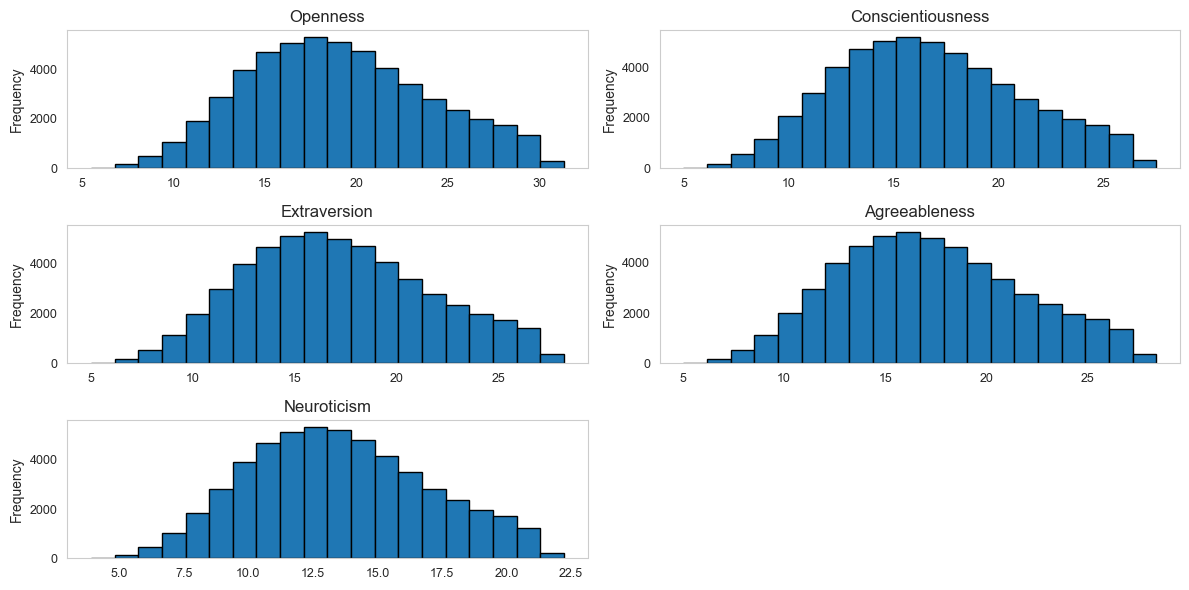

In [140]:
plot(res_min_max)

It seems that by using the full range from 0 to 1, an almost uniform distribution was created, which is not entirely accurate. Therefore, we need to look for another standardization method that provides greater variability.

## Softmax

This is similar to dividing by the total sum, but with greater differentiation, making higher ratings carry more weight. We want the most appreciated genres to strongly define the personality.

- Effect: It will make genres with high ratings dominate, even if the user has seen few of those genres.
- Expected Distribution: Slightly biased towards genres with high ratings. A more concentrated distribution with less dispersion, but genres that the user rated higher will be given more weight. Although this may distort the actual personality if the user rated a genre highly that they barely watched.

In [141]:
def softmax_df(df):
    # Resta el máximo de cada fila para estabilidad numérica
    exp_df = np.exp(df.sub(df.max(axis=1), axis=0))
    # Divide por la suma de cada fila
    return exp_df.div(exp_df.sum(axis=1), axis=0)

In [142]:
df_softmax = softmax_df(df)
df_softmax.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,0.211236,0.112061,0.003635,0.099302,0.137214,0.003635,0.123259,0.198438,0.111222
3,0.106542,0.109864,0.155516,0.071628,0.179228,0.013266,0.111075,0.091266,0.161614
18,0.048173,0.080300,0.166490,0.099968,0.134345,0.227565,0.090519,0.068923,0.083716
20,0.117395,0.124653,0.165830,0.117006,0.095608,0.134974,0.078525,0.096713,0.069298
29,0.068252,0.080147,0.230308,0.105810,0.129085,0.051389,0.128055,0.067266,0.139689


In [143]:
res = df_softmax @ personality
res.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,3.912152,3.482784,3.568000,3.588749,2.731283
3,3.927436,3.438800,3.523652,3.549377,2.782517
18,3.930453,3.411934,3.512763,3.525626,2.825106
20,3.928795,3.426085,3.512393,3.540360,2.798066
29,3.932816,3.412436,3.498843,3.527363,2.809282


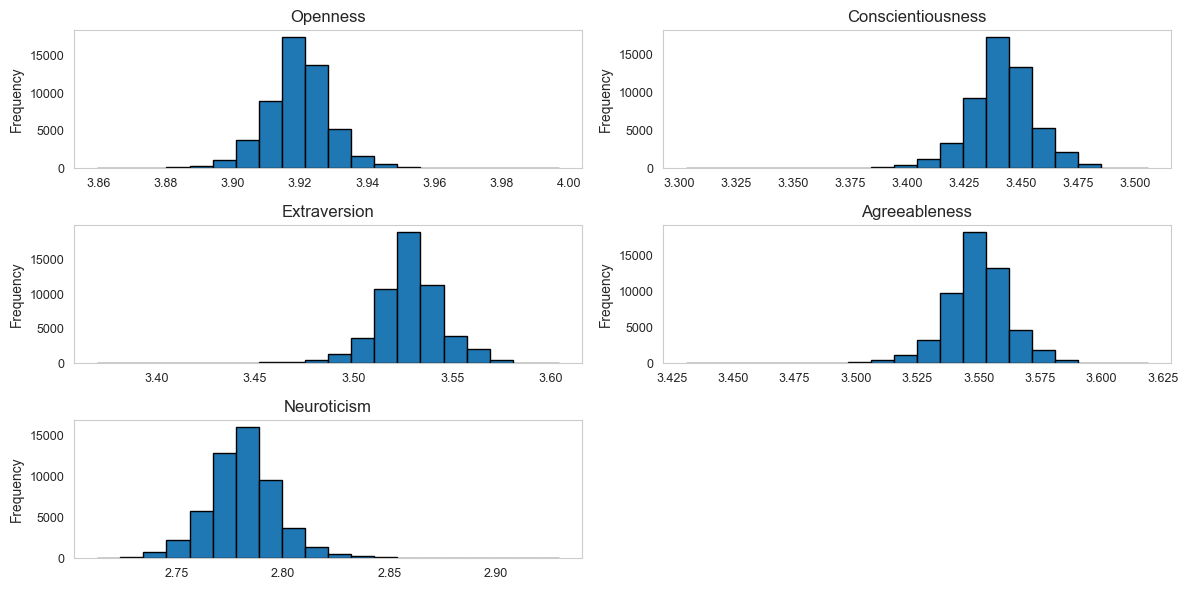

In [144]:
plot(res)

As expected, the result was almost the same as the standardization with division by the total sum, due to the fact that the variance between the personality matrix and the ratings is very low, respectively. One difference is that this distribution follows a normal shape, making it the best so far. We would only need to scale it from 1 to 5 to increase its variance.

In [145]:
scaler = MinMaxScaler(feature_range=(1, 5))
scaled = scaler.fit_transform(res)
scaled = pd.DataFrame(scaled, columns=['OPE', 'CON', 'EXT', 'AGR', 'NEU'])
scaled.head()

,OPE,CON,EXT,AGR,NEU
0,2.527771,4.554165,4.384315,4.359904,1.348021
1,2.972565,3.683933,3.625809,3.522680,2.289669
2,3.060382,3.152396,3.439580,3.017624,3.072422
3,3.012125,3.432362,3.433250,3.330934,2.575457
4,3.129144,3.162316,3.201502,3.054576,2.781587


Here, scaling from 1 to 5 with Min-Max seems to not distort the values as extremely as we saw earlier, making it an option to consider. This happened because, although all distributions are normal, they have different means and standard deviations, resulting in a greater difference.

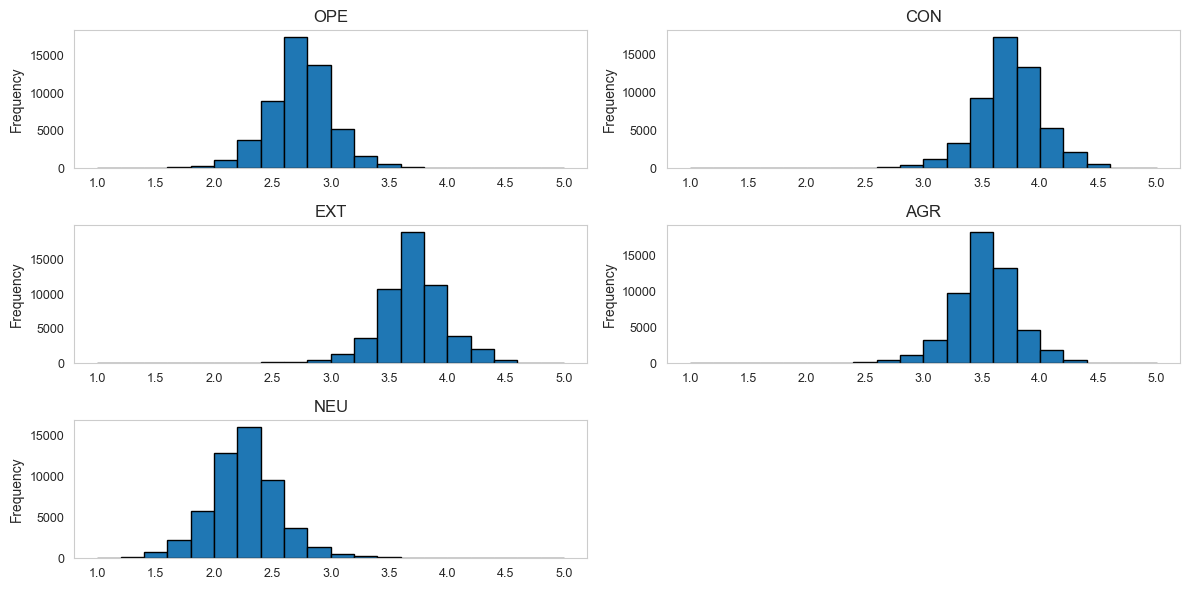

In [146]:
plot(scaled)

### With Weighted Genres

Multiply by the percentage of movies watched in that genre. To create a difference between users' ratings, we will multiply the percentage of movies watched in each genre by the rating of that genre, respectively.

- Effect: Gives more weight to the genres where the user has watched more movies, regardless of whether they rated them high or low.
- Expected Distribution: More realistic in terms of which genres influence the personality. If the user has watched many genres evenly, the distribution will be more uniform. If they have predominantly watched one genre, the distribution will be biased toward that category.

In [147]:
weighted_ratings = df * genre_proportions
weighted_ratings.head()

genres,Action,Adventure,Animation,Comedy,Drama,Horror,Romance,Science Fiction,War
userId,,,,,,,,,
1,0.246212,0.181818,0.000000,0.651515,1.416667,0.000000,0.560606,0.272727,0.246212
3,0.686901,0.658147,0.164537,0.519169,0.760383,0.004792,0.324281,0.383387,0.127796
18,0.223108,0.330677,0.266932,0.908367,1.171315,0.053785,0.456175,0.237052,0.041833
20,0.669355,0.695565,0.288306,0.653226,0.854839,0.032258,0.167339,0.354839,0.080645
29,0.384328,0.197761,0.089552,0.541045,1.212687,0.018657,0.585821,0.134328,0.078358


In [148]:
personality_scores = weighted_ratings @ personality
personality_scores.head(10)

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,14.047992,12.357955,12.891439,12.860758,9.918598
3,14.239489,12.577987,12.950224,13.045176,9.971166
18,14.518147,12.688247,13.199721,13.227371,10.277291
20,14.919093,13.120444,13.512379,13.617560,10.482581
29,12.741306,11.169216,11.673433,11.656306,9.009067
33,16.434580,14.463241,14.921084,14.976648,11.575509
34,14.244879,12.549595,12.991134,13.066134,9.998684
36,14.077642,12.380967,12.815849,12.854057,9.905660
37,11.670386,10.307918,10.642189,10.690365,8.179592


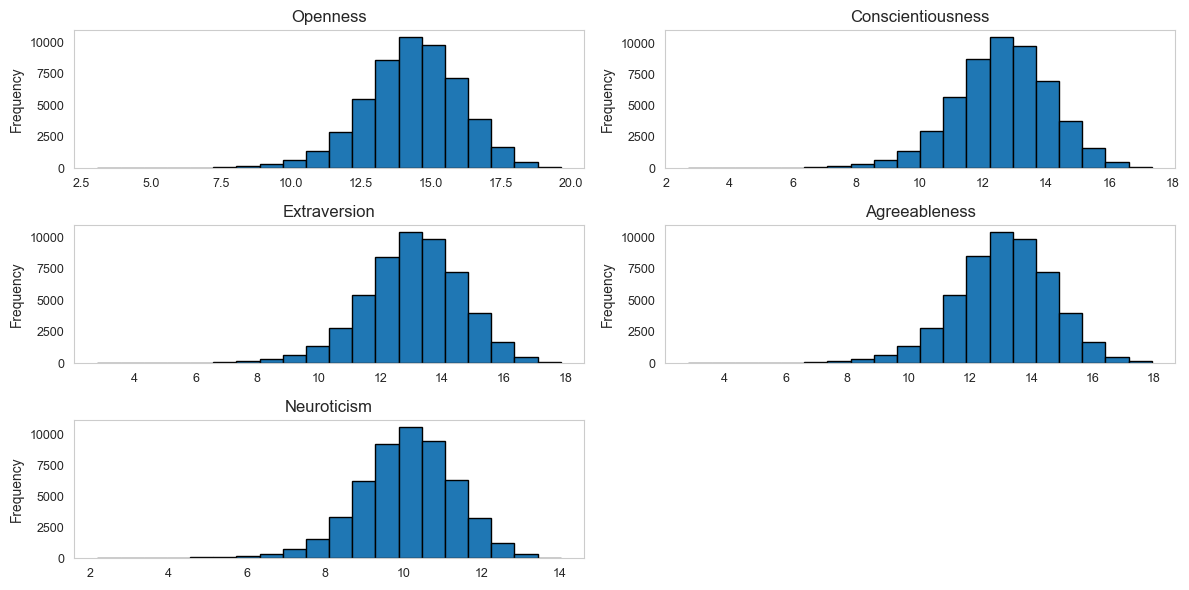

In [149]:
plot(personality_scores)

This method seems to be very good so far. The disadvantages are that we are giving too much weight to the most viewed genres, regardless of whether they have a low rating, and the ratings are not standardized. Therefore, we will test a mix between Softmax and weighted genres.

### 50% Genre Percentage and 50% Ratings

We will assign a 50% weight to the Softmax standardization and a 50% weight to the percentage of genres watched by the user.

In [293]:
combined_scores = (df_softmax * 0.5) + (weighted_ratings * 0.4)
res = combined_scores @ personality
# Delete outliers
z_scores = (res - res.mean()) / res.std()
res = res[(np.abs(z_scores) <= 2.8).all(axis=1)]
res.head(10)

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,7.575273,6.684574,6.940576,6.938677,5.333081
3,7.659513,6.750595,6.941915,6.992759,5.379725
18,7.772486,6.781266,7.036270,7.053761,5.523469
20,7.932035,6.961220,7.161148,7.217204,5.592065
29,7.062930,6.173904,6.418795,6.426204,5.008268
33,8.535338,7.501849,7.729998,7.761413,6.027285
34,7.661553,6.737708,6.961074,7.004338,5.391061
36,7.590837,6.671543,6.890357,6.913900,5.357511
37,6.622509,5.853140,6.036736,6.063968,4.649073


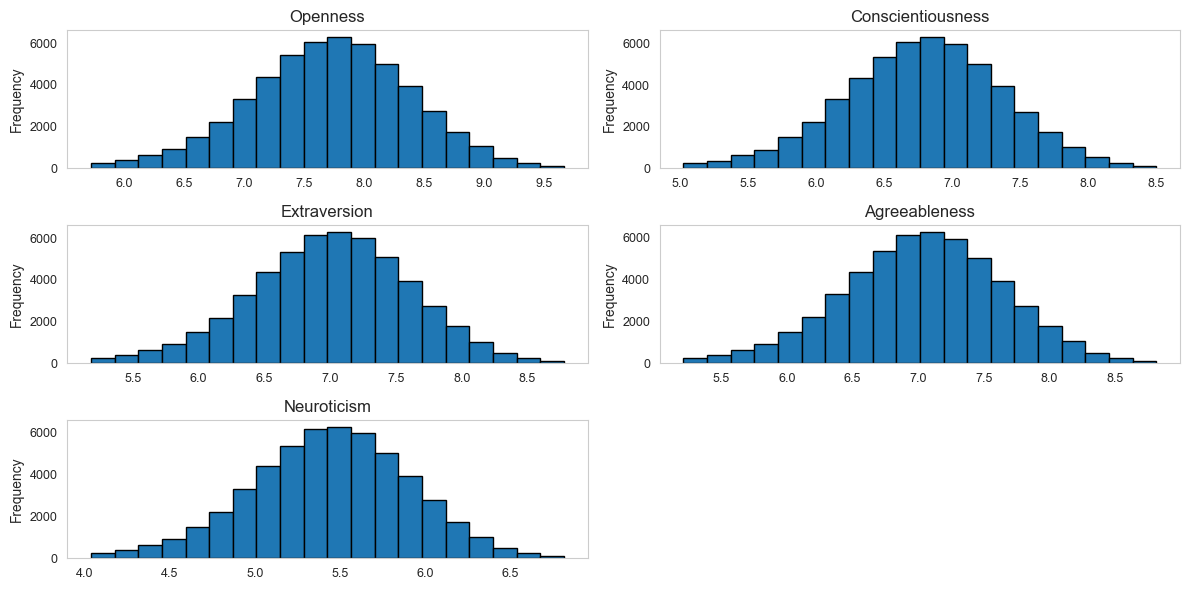

In [294]:
plot(res)

In [295]:
res.std()

Openness             0.663043
Conscientiousness    0.584562
Extraversion         0.601983
Agreeableness        0.605810
Neuroticism          0.464919
dtype: float64

Now we will rescale the scores to the original scale (1-5) using the z-score scaling.

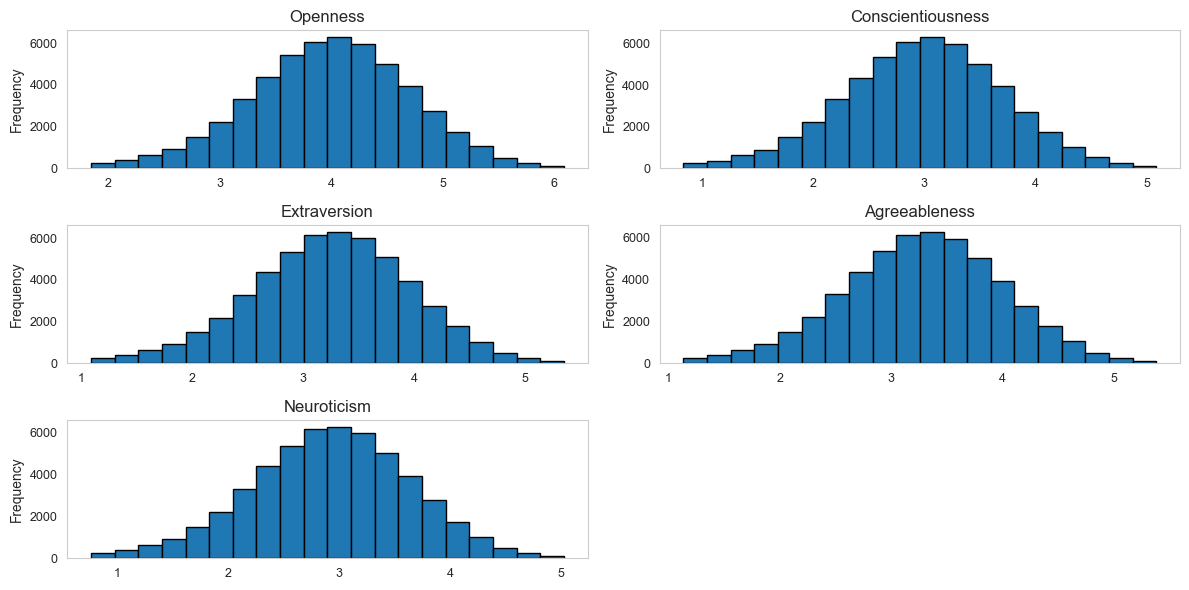

In [311]:
columns = {'Openness': 3, 'Conscientiousness': 3, 'Extraversion': 3, 'Agreeableness': 3, 'Neuroticism': 5}

z_scores = pd.DataFrame()

for column, value in columns.items():
    mu = np.mean(res)
    sigma = np.std(res[column])
    z_scores[column] = (res[column] - mu) / (1.4 * sigma) + value

plot(z_scores)

In [312]:
z_scores.head(10)

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,3.840782,2.865293,3.172954,3.169624,2.754219
3,3.931534,2.945966,3.174544,3.233389,2.825883
18,4.053238,2.983444,3.286502,3.305315,3.046728
20,4.225120,3.203334,3.434678,3.498026,3.152118
29,3.288839,2.241291,2.553827,2.565381,2.255183
33,4.875054,3.863945,4.109656,4.139687,3.820781
34,3.933731,2.930219,3.197277,3.247042,2.843299
36,3.857550,2.849371,3.113366,3.140409,2.791754
37,2.814375,1.849340,2.100488,2.138279,1.703324


## Conclusions

The best approach is to extract personality profiles using a 50-50 mix, then scale the results using Z-score normalization. This method helps us better capture users' true preferences by giving equal weight to their highest-rated genres and their most-watched genres. As expected, the resulting distribution was approximately normal, which is ideal, since the personality traits follow a normal distribution, and this also allowed us to effectively scale the values to the desired range using Z-score.

### Save the personality traits 

Save it in a csv file, with just 2 decimals

In [316]:
for column in z_scores.columns:
    z_scores[column] = z_scores[column].round(2)
    
z_scores.head()

,Openness,Conscientiousness,Extraversion,Agreeableness,Neuroticism
userId,,,,,
1,3.84,2.87,3.17,3.17,2.75
3,3.93,2.95,3.17,3.23,2.83
18,4.05,2.98,3.29,3.31,3.05
20,4.23,3.20,3.43,3.50,3.15
29,3.29,2.24,2.55,2.57,2.26


In [317]:
z_scores.to_csv('../Data/Processed/personality.csv')